In [8]:
import os
import random
import sys

import numpy as np
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset

sys.path.append("../")
from viz_utils import NdimageVisualizer

In [9]:
np.random.seed(0)
random.seed(0)

In [10]:
visualizer = NdimageVisualizer()

In [11]:
def load(file_path):
    reader = sitk.ImageFileReader()
    reader.SetFileName(str(file_path))
    sitk_image = reader.Execute()
    return sitk_image

def get_npy(sitk_image):
    return sitk.GetArrayFromImage(sitk_image)

In [20]:
UNPAIRED_SAMPLING_SCHEMES = ('uniform-random-within-body-sf', 'fdg-pet-weighted-sf')

class UnpairedPatchSampler3D():
    """3D patch sampler for unpaired training.

    Variations of Stochastic Focal patch sampling, where different schemes 
    differ in the way the focal point is sampled from domain A image(s).
    Essentially, the schemes implement different "prior" patch sampling 
    probability distributions.


    Available patch sampling schemes:
        1. 'uniform-random-sf'
        2. 'fdg-pet-weighted-sf'
    """
    def __init__(self, patch_size, sampling, focal_region_proportion):

        if sampling not in UNPAIRED_SAMPLING_SCHEMES:
            raise ValueError(f"`{sampling}` not a valid unpaired patch sampling scheme. \
                               Available schemes: {UNPAIRED_SAMPLING_SCHEMES}")

        self.patch_size = np.array(patch_size)
        self.sampling = sampling
        self.focal_region_proportion = np.array(focal_region_proportion)


    def get_patch_pair(self, image_dict_A, image_dict_B):
        # Sample a focal point and its size-normlaized version for domain A images
        focal_point_A, relative_focal_point = self._sample_focal_point_A(image_dict_A)

        # Sample a focal point for B images that is in relative neighborhood of the focal point of A images
        focal_point_B = self._sample_focal_point_B(image_dict_B, relative_focal_point)

        # Extract patches from all volumes given this focal point and the patch size
        start_idx_A = focal_point_A - np.floor(self.patch_size/2)
        end_idx_A = start_idx_A + self.patch_size
        z1_A, y1_A, x1_A = start_idx_A.astype(np.uint16)
        z2_A, y2_A, x2_A = end_idx_A.astype(np.uint16)

        start_idx_B = focal_point_B - np.floor(self.patch_size/2)
        end_idx_B = start_idx_B + self.patch_size
        z1_B, y1_B, x1_B = start_idx_B.astype(np.uint16)
        z2_B, y2_B, x2_B = end_idx_B.astype(np.uint16)
    
        patch_dict_A = {}
        for k in image_dict_A.keys():
            patch_dict_A[k] = image_dict_A[k][z1_A:z2_A, y1_A:y2_A, x1_A:x2_A]
        
        patch_dict_B = {}
        for k in image_dict_B.keys():
            patch_dict_B[k] = image_dict_B[k][z1_B:z2_B, y1_B:y2_B, x1_B:x2_B]
        
        return patch_dict_A, patch_dict_B


    def _sample_focal_point_A(self, image_dict_A):
        body_mask = image_dict_A['body-mask']
        volume_size = body_mask.shape  # DHW

        # Initialize sampling probability map as a volumetric mask of body region contained inside the 
        # volume's valid patch region (i.e. suffieciently away from the volume borders)
        sampling_prob_map = sampling_prob_map = init_sampling_probability_map(volume_size, self.patch_size, body_mask)

        # Depending on the sampling technique, construct the probability map
        if self.sampling == 'uniform-random-within-body-sf':
            # Uniform random over all valid focal points
            sampling_prob_map = sampling_prob_map / np.sum(sampling_prob_map)

        elif self.sampling == 'fdg-pet-weighted-sf':
            # Random sampling, biased to high SUV regions in FDG-PET
            FDG_PET_volume = image_dict_A['FDG-PET']
            # Clip negative values to zero 
            FDG_PET_volume = np.clip(FDG_PET_volume, 0, None)
            # Update the probability map
            sampling_prob_map = sampling_prob_map * FDG_PET_volume
            sampling_prob_map = sampling_prob_map / np.sum(sampling_prob_map)

        # Sample focal point using this probability map
        focal_point = sample_from_probability_map(sampling_prob_map)
        focal_point = np.array(focal_point)

        # Calculate the relative focal point by normalizing focal point indices with the volume size
        relative_focal_point = focal_point / np.array(volume_size)

        return focal_point.astype(np.uint16), relative_focal_point


    def _sample_focal_point_B(self, image_dict_B, relative_focal_point):
        body_mask = image_dict_B['body-mask']
        volume_size = body_mask.shape  # DHW

        focal_region_size = self.focal_region_proportion * np.array(volume_size)
        focal_region_size = focal_region_size.astype(np.uint16)

        # Map relative point to corresponding point in this volume
        focal_point = relative_focal_point * np.array(volume_size)

        # Intialize a sampling probability map for domain B images
        sampling_prob_map = init_sampling_probability_map(volume_size, self.patch_size, body_mask)

        # Apply Stochastic focal sampling
        focal_point_after_sf = self._apply_stochastic_focal_method(focal_point, focal_region_size, sampling_prob_map)
        return focal_point_after_sf


    def _apply_stochastic_focal_method(self, focal_point, focal_region_size, sampling_prob_map):
        
        # Create a focal region mask having the same size as the volume      
        volume_size = sampling_prob_map.shape       
        focal_region_min, focal_region_max = [], [] 
        for axis in range(len(focal_point)):
            # Find the lowest and highest position between which to focus for this axis
            min_position = int(focal_point[axis] - focal_region_size[axis] / 2)
            max_position = int(focal_point[axis] + focal_region_size[axis] / 2)            

            # If one of the boundaries of the focus is outside of the volume size, cap it
            min_position = max(min_position, 0)
            max_position = min(max_position, volume_size[axis])

            focal_region_min.append(min_position)
            focal_region_max.append(max_position)

        z_min, y_min, x_min = focal_region_min
        z_max, y_max, x_max = focal_region_max        
        focal_region_mask = np.zeros_like(sampling_prob_map)
        focal_region_mask[z_min:z_max, y_min:y_max, x_min:x_max] = 1

        # Update the sampling map by taking the intersection with the focal region mask.
        # This is to make sure the sampled focal point is:  
        #   1. Within the volume's valid region  
        #   2. AND, Within body region 
        #   3. AND, Within focal region
        intersection_mask = sampling_prob_map * focal_region_mask
        if 1 not in list(np.unique(intersection_mask)):
            # Edge case: If no intersection region is found between (1+2) and (3),
            # just sample a B-image patch from anywhere within (1+2) region, i.e. valid body region
            print("Stochastic focal sampling failed in a domain B image. Possible reason may be too small `focal_region_proportion` value. Sampling a random valid patch from within the body region.")
            sampling_prob_map = sampling_prob_map / np.sum(sampling_prob_map)
            focal_point_B = sample_from_probability_map(sampling_prob_map)
            return focal_point_B, focal_region_mask  ##
        
        # Otherwise, continue with using the intersection mask and update the sampling probability map
        sampling_prob_map = intersection_mask / np.sum(intersection_mask)

        # Sample focal point using this updated probability map
        focal_point_after_sf = sample_from_probability_map(sampling_prob_map)
        return focal_point_after_sf, focal_region_mask  ##



# --------------
# Util functions

def sample_from_probability_map(sampling_prob_map):
    """TODO: Doc
    """
    # Check if samplig prob map is a proper distribution (i.e. its sum is approx. equal to 1)
    epsilon = 0.001
    assert np.sum(sampling_prob_map) > 1 - epsilon and np.sum(sampling_prob_map) < 1 + epsilon 

    # Select relevant indices to sample from (i.e. those having a non-zero probability)
    relevant_idxs = np.argwhere(sampling_prob_map > 0)

    # Using the sampling probability map, define the sampling distribution over these relevant indices
    distribution = sampling_prob_map[sampling_prob_map > 0].flatten()
    
    # Sample a single voxel index. This is the focal point.
    s = np.random.choice(len(relevant_idxs), p=distribution)
    sampled_idx = relevant_idxs[s]
    
    return sampled_idx


def init_sampling_probability_map(volume_size, patch_size, body_mask):
    """Initialize sampling probability map as a volumetric mask of body region contained inside the 
    volume's valid patch region (i.e. suffieciently away from the volume borders)
    """
    # Initialize sampling probability map as zeros
    sampling_prob_map = np.zeros(volume_size)

    # Get valid index range for focal points - upper-bound inclusive   
    valid_foc_pt_idx_min, valid_foc_pt_idx_max = get_valid_region_corner_points(volume_size, patch_size)
    z_min, y_min, x_min = valid_foc_pt_idx_min.astype(np.uint16)
    z_max, y_max, x_max = valid_foc_pt_idx_max.astype(np.uint16)

    # Set valid zone values as 1
    sampling_prob_map[z_min:z_max, y_min:y_max, x_min:x_max] = 1

    # Filter out those outside the body region. To avoid sampling patches from the background areas.
    sampling_prob_map = sampling_prob_map * body_mask

    return sampling_prob_map


def get_valid_region_corner_points(volume_size, patch_size):
    valid_foc_pt_idx_min = np.zeros(3) + np.floor(patch_size/2)
    valid_foc_pt_idx_max = np.array(volume_size) - np.ceil(patch_size/2)   
    return valid_foc_pt_idx_min.astype(np.int16), valid_foc_pt_idx_max.astype(np.int16)


In [21]:
DATA_DIR = "/home/chinmay/Datasets/HX4-PET-Translation/Processed/train"
PATIENT = "PB113"  # PB113 has only 33 slices in HX4-PET and ldCT

PATCH_SIZE = (32, 128, 128)
PATCH_SAMPLING = 'uniform-random-within-body-sf'
FOCAL_REGION_PROPORTION = [0.6, 0.25, 0.25]

In [22]:
images_A, images_B = {}, {}
images_A['FDG-PET'] = get_npy(load(f"{DATA_DIR}/{PATIENT}/fdg_pet.nrrd"))
images_A['pCT'] = get_npy(load(f"{DATA_DIR}/{PATIENT}/pct.nrrd"))
images_A['body-mask'] = get_npy(load(f"{DATA_DIR}/{PATIENT}/pct_body.nrrd"))
images_B['HX4-PET'] = get_npy(load(f"{DATA_DIR}/{PATIENT}/hx4_pet.nrrd")  )
images_B['ldCT'] = get_npy(load(f"{DATA_DIR}/{PATIENT}/ldct.nrrd"))
images_B['body-mask'] = get_npy(load(f"{DATA_DIR}/{PATIENT}/ldct_body.nrrd"))

In [23]:
patch_sampler = UnpairedPatchSampler3D(PATCH_SIZE, PATCH_SAMPLING, FOCAL_REGION_PROPORTION)

sampling_prob_map_A shape: (45, 480, 500)


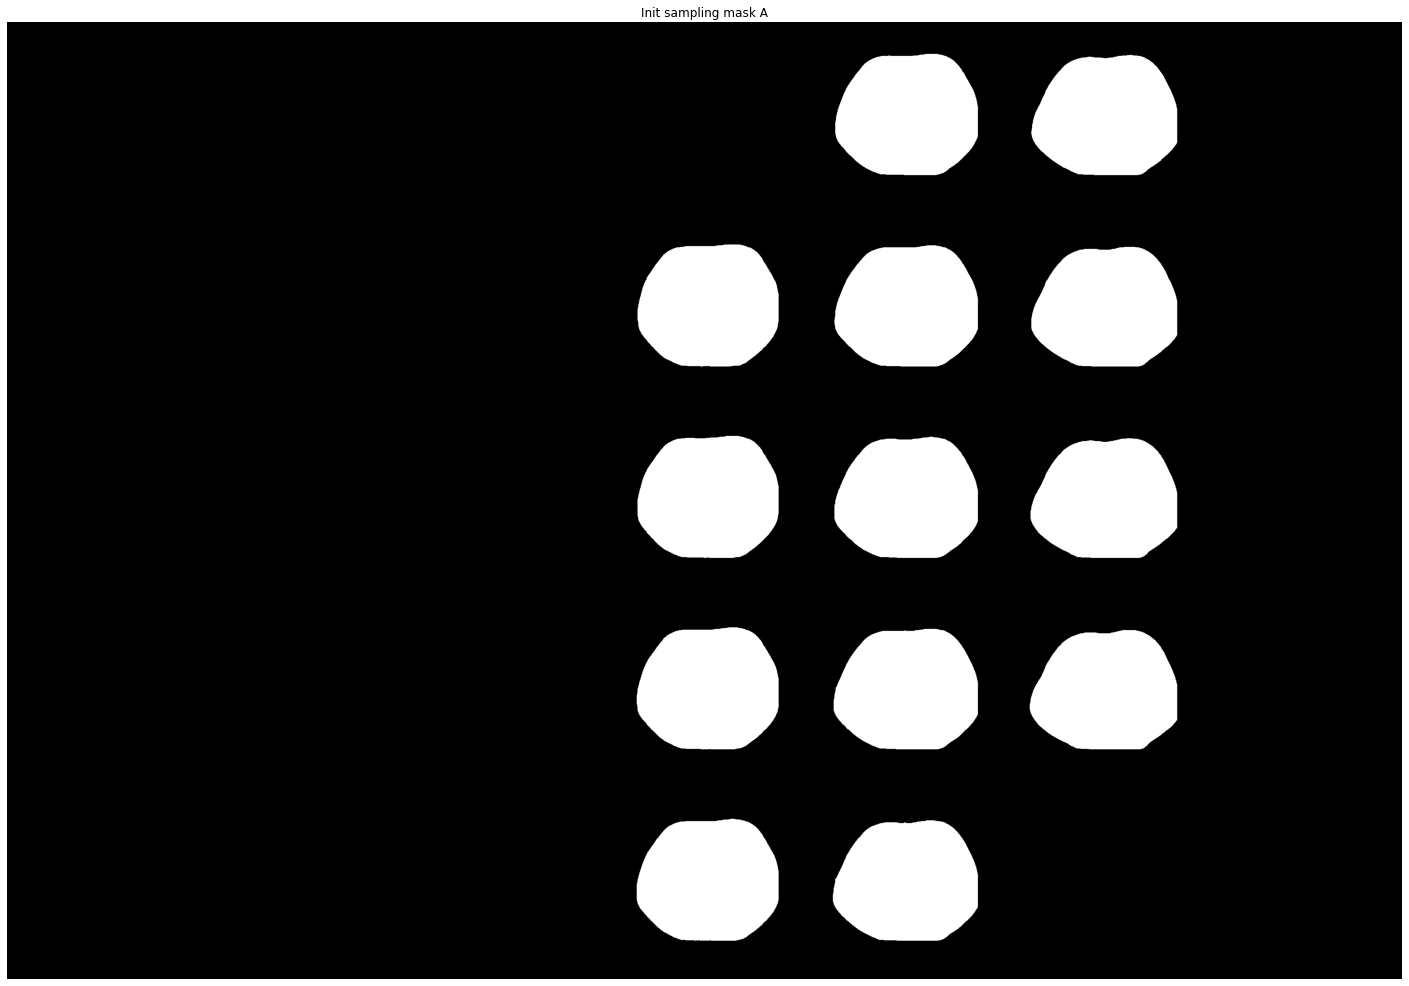

Focal points with most extreme x, y, z coords:
Z: [ 16  77 322] [ 28  85 298]
Y: [ 16  77 322] [ 16 383 240]
X: [ 28 270  66] [ 16 201 435]
Extreme combinations of x,y,z:
Min:  [ 16  77 322]
Max:  [ 28 383 343]


In [24]:
# A images

volume_size_A = images_A['body-mask'].shape[-3:]
sampling_prob_map_A = init_sampling_probability_map(volume_size_A, np.array(PATCH_SIZE), images_A['body-mask'])
print("sampling_prob_map_A shape:", sampling_prob_map_A.shape)
visualizer.grid(sampling_prob_map_A.transpose(2,1,0), 
                idx_range=[0,33], view='axial', image_type='labelmap', title="Init sampling mask A")

valid_body_region_voxels_coords = np.argwhere(sampling_prob_map_A)
print("Focal points with most extreme x, y, z coords:")
min_z_voxel, max_z_voxel = valid_body_region_voxels_coords[:, 0].argmin(), valid_body_region_voxels_coords[:, 0].argmax()
min_y_voxel, max_y_voxel = valid_body_region_voxels_coords[:, 1].argmin(), valid_body_region_voxels_coords[:, 1].argmax()
min_x_voxel, max_x_voxel = valid_body_region_voxels_coords[:, 2].argmin(), valid_body_region_voxels_coords[:, 2].argmax()

min_z_focal_point_A, max_z_focal_point_A = valid_body_region_voxels_coords[min_z_voxel], valid_body_region_voxels_coords[max_z_voxel]
min_y_focal_point_A, max_y_focal_point_A = valid_body_region_voxels_coords[min_y_voxel], valid_body_region_voxels_coords[max_y_voxel]
min_x_focal_point_A, max_x_focal_point_A = valid_body_region_voxels_coords[min_x_voxel], valid_body_region_voxels_coords[max_x_voxel]

print("Z:", min_z_focal_point_A, max_z_focal_point_A)
print("Y:", min_y_focal_point_A, max_y_focal_point_A)
print("X:", min_x_focal_point_A, max_x_focal_point_A)


print("Extreme combinations of x,y,z:")
min_zyx_combination_focal_point_A = valid_body_region_voxels_coords[0]
max_zyx_combination_focal_point_A = valid_body_region_voxels_coords[-1]
print("Min: ", min_zyx_combination_focal_point_A)
print("Max: ", max_zyx_combination_focal_point_A)

(33, 576, 576)


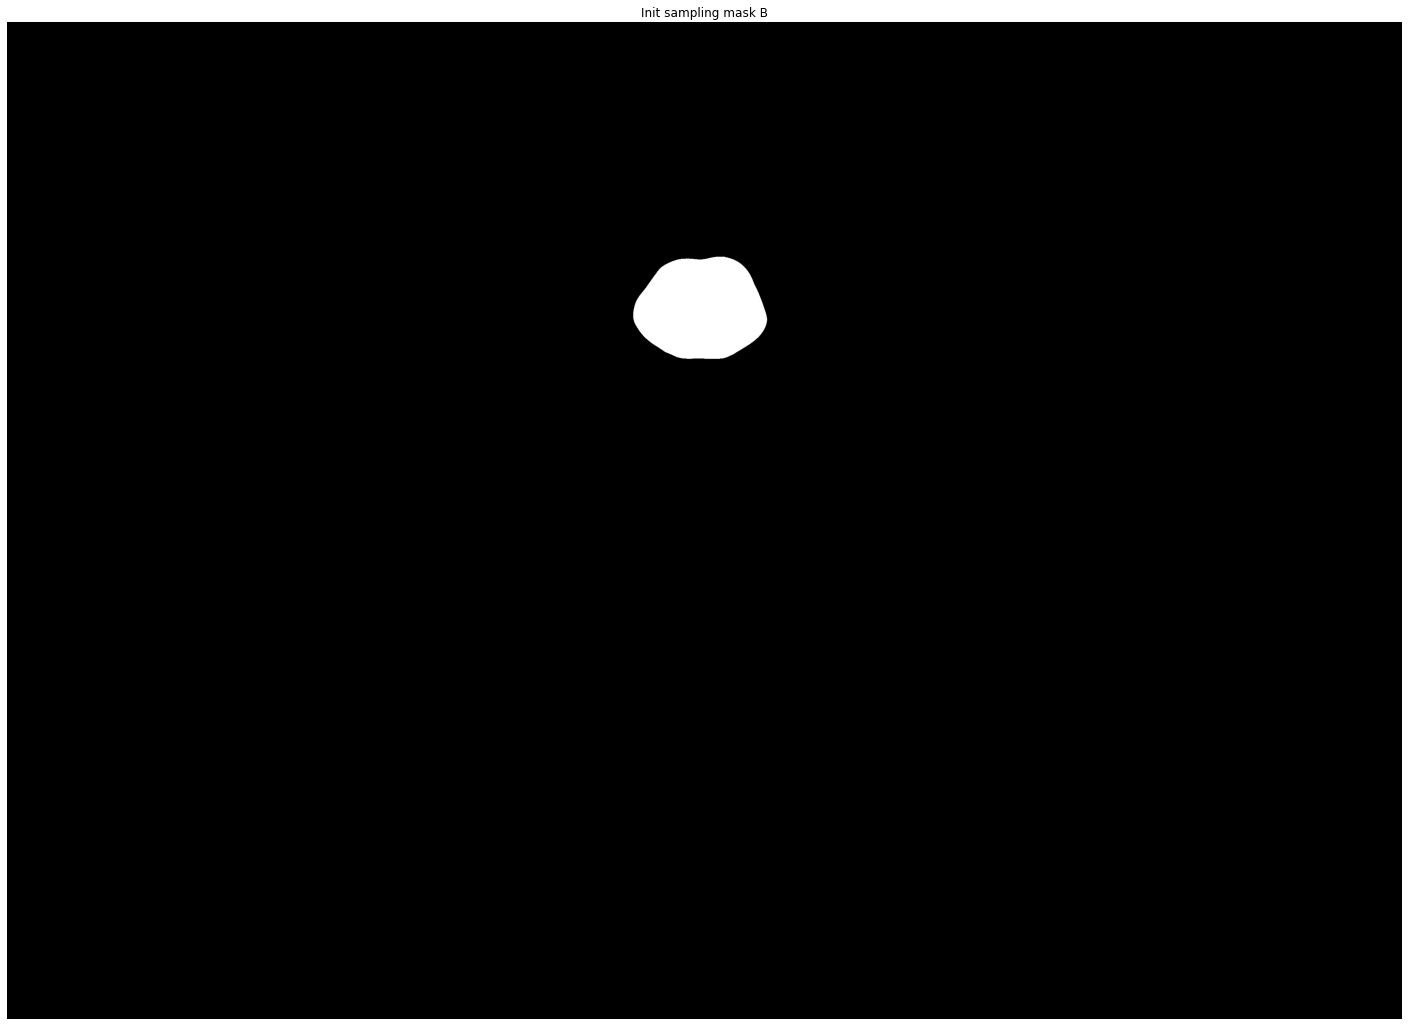

Focal points with most extreme x, y, z coords:
Z: [ 16 102 320] [ 16 102 320]
Y: [ 16 102 320] [ 16 396 236]
X: [ 16 260  82] [ 16 279 468]
Extreme combinations of x,y,z:
Min:  [ 16 102 320]
Max:  [ 16 396 332]


In [25]:
# B images

volume_size_B = images_B['body-mask'].shape[-3:]
sampling_prob_map_B = init_sampling_probability_map(volume_size_B, np.array(PATCH_SIZE), images_B['body-mask'])
print(sampling_prob_map_B.shape)
visualizer.grid(sampling_prob_map_B.transpose(2,1,0), 
                idx_range=[0,33], view='axial', image_type='labelmap', title="Init sampling mask B")


valid_body_region_voxels_coords = np.argwhere(sampling_prob_map_B)
print("Focal points with most extreme x, y, z coords:")
min_z_voxel, max_z_voxel = valid_body_region_voxels_coords[:, 0].argmin(), valid_body_region_voxels_coords[:, 0].argmax()
min_y_voxel, max_y_voxel = valid_body_region_voxels_coords[:, 1].argmin(), valid_body_region_voxels_coords[:, 1].argmax()
min_x_voxel, max_x_voxel = valid_body_region_voxels_coords[:, 2].argmin(), valid_body_region_voxels_coords[:, 2].argmax()

min_z_focal_point_B, max_z_focal_point_B = valid_body_region_voxels_coords[min_z_voxel], valid_body_region_voxels_coords[max_z_voxel]
min_y_focal_point_B, max_y_focal_point_B = valid_body_region_voxels_coords[min_y_voxel], valid_body_region_voxels_coords[max_y_voxel]
min_x_focal_point_B, max_x_focal_point_B = valid_body_region_voxels_coords[min_x_voxel], valid_body_region_voxels_coords[max_x_voxel]

print("Z:", min_z_focal_point_B, max_z_focal_point_B)
print("Y:", min_y_focal_point_B, max_y_focal_point_B)
print("X:", min_x_focal_point_B, max_x_focal_point_B)


print("Extreme combinations of x,y,z:")
min_zyx_combination_focal_point_B = valid_body_region_voxels_coords[0]
max_zyx_combination_focal_point_B = valid_body_region_voxels_coords[-1]
print("Min: ", min_zyx_combination_focal_point_B)
print("Max: ", max_zyx_combination_focal_point_B)

focal_region_size:  [ 19 144 144]
focal_point_after_sf:  [ 16 149 371]


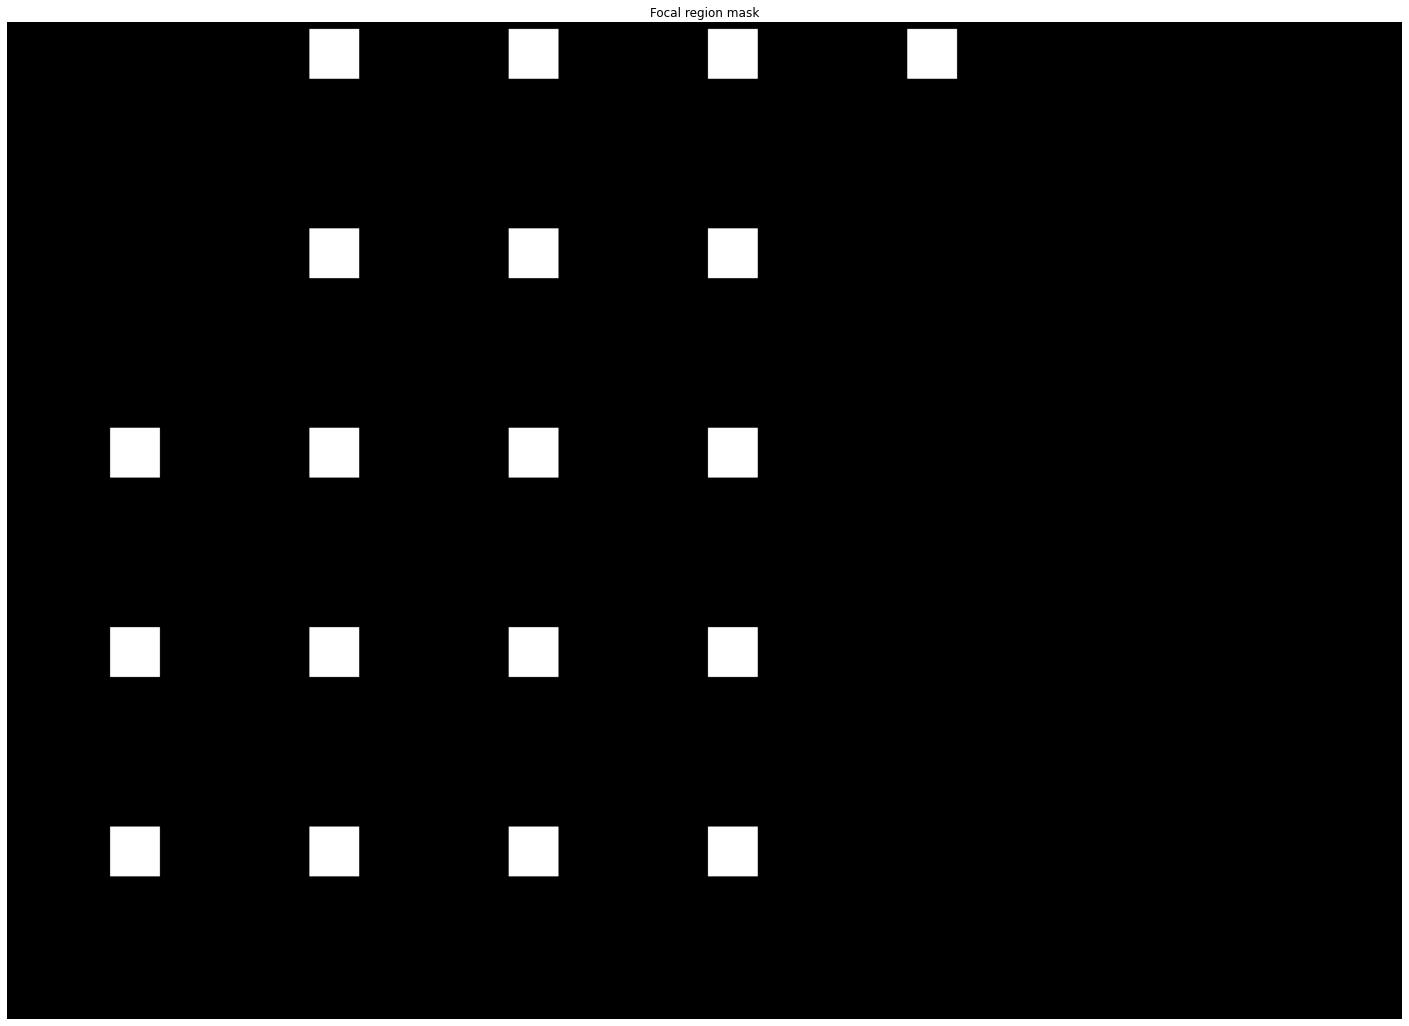

In [26]:
# Scenario 1: Min possible XYZ combination focal point of A

relative_focal_point = min_zyx_combination_focal_point_A / np.array(volume_size_A)
focal_point_on_B = relative_focal_point * np.array(volume_size_B)

focal_region_size = FOCAL_REGION_PROPORTION * np.array(volume_size_B)
focal_region_size = focal_region_size.astype(np.uint16)
print("focal_region_size: ", focal_region_size)
    
# Apply Stochastic focal sampling
focal_point_after_sf, intersection_mask = patch_sampler._apply_stochastic_focal_method(focal_point_on_B, focal_region_size, sampling_prob_map_B)
print("focal_point_after_sf: ", focal_point_after_sf)
visualizer.grid(intersection_mask.transpose(2,1,0), 
                idx_range=[0,33], view='axial', image_type='labelmap', title="Focal region mask")

focal_region_size:  [ 19 144 144]
Stochastic focal sampling failed in a domain B image. Sampling a random valid patch from within the body region.
focal_point_after_sf:  [ 16 278 362]


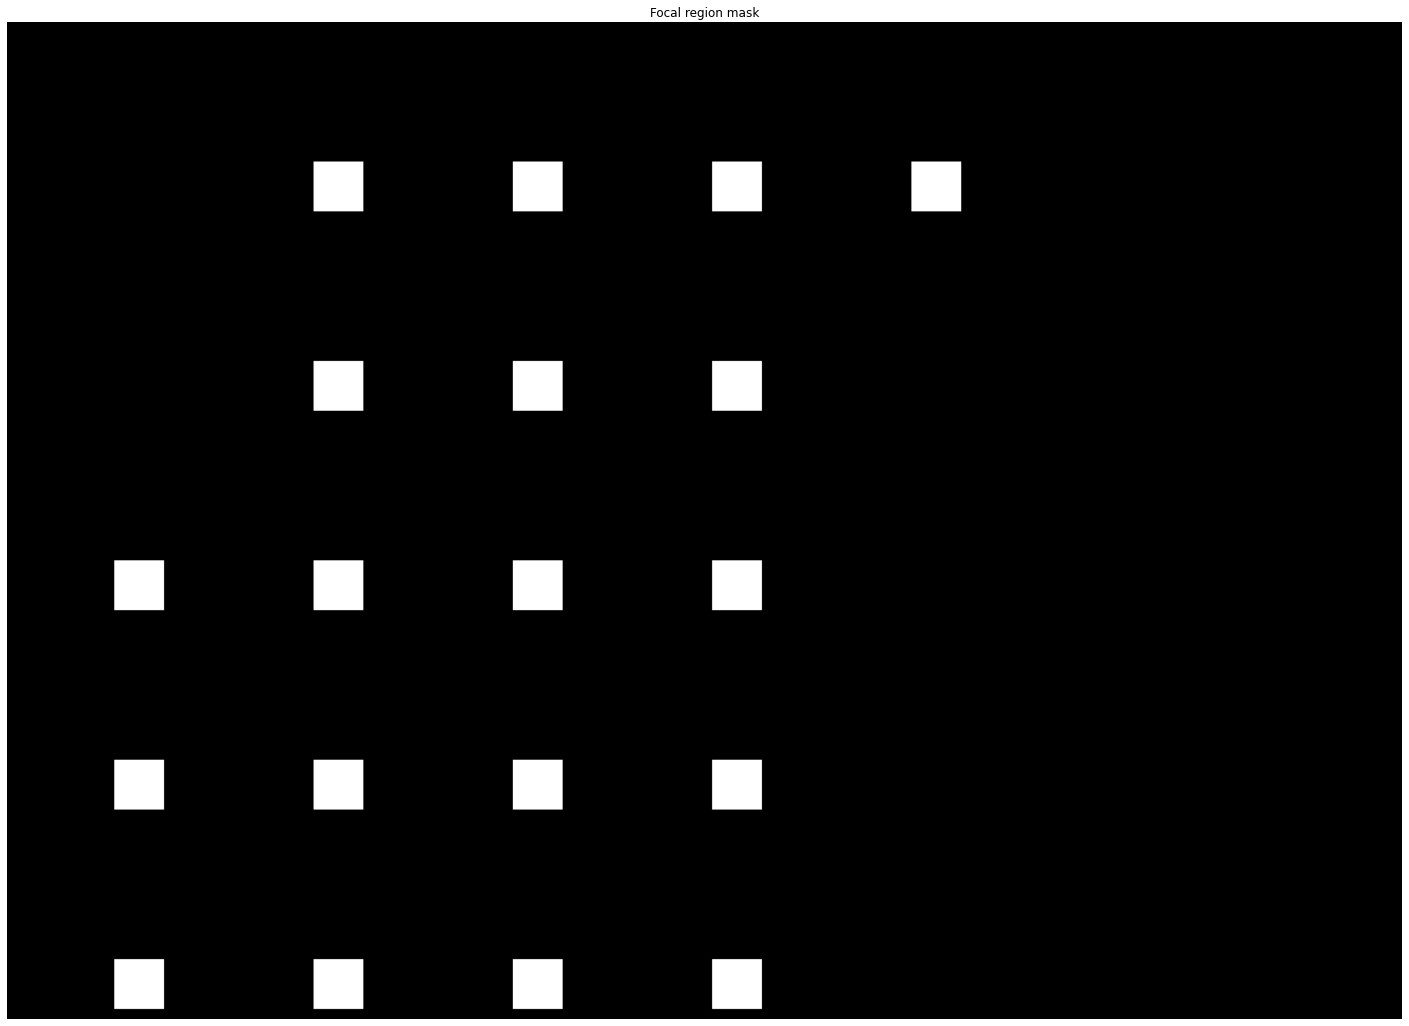

In [27]:
# Scenario 2: Max possible XYZ combination focal point of A

relative_focal_point = max_zyx_combination_focal_point_B / np.array(volume_size_A)
focal_point_on_B = relative_focal_point * np.array(volume_size_B)

focal_region_size = FOCAL_REGION_PROPORTION * np.array(volume_size_B)
focal_region_size = focal_region_size.astype(np.uint16)
print("focal_region_size: ", focal_region_size)
    
# Apply Stochastic focal sampling
focal_point_after_sf, intersection_mask = patch_sampler._apply_stochastic_focal_method(focal_point_on_B, focal_region_size, sampling_prob_map_B)
print("focal_point_after_sf: ", focal_point_after_sf)
visualizer.grid(intersection_mask.transpose(2,1,0), 
                idx_range=[0,33], view='axial', image_type='labelmap', title="Focal region mask")

focal_region_size:  [ 19 144 144]
focal_point_after_sf:  [ 16 140 354]


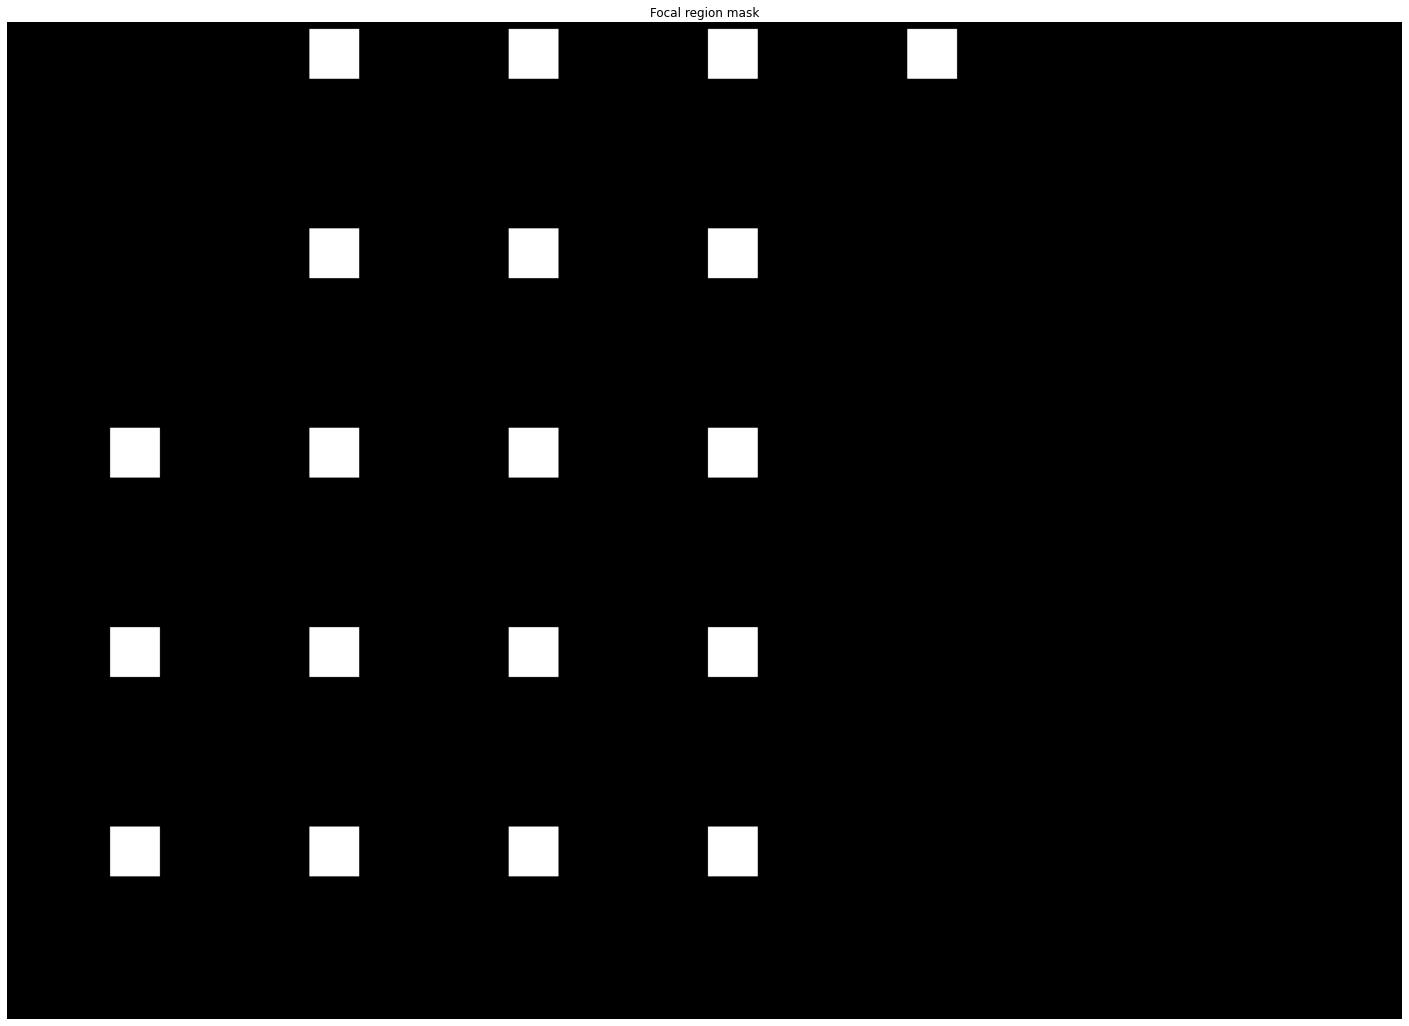

In [28]:
# Scenario 3: Min possible Z focal point of A

relative_focal_point = min_z_focal_point_A / np.array(volume_size_A)
focal_point_on_B = relative_focal_point * np.array(volume_size_B)

focal_region_size = FOCAL_REGION_PROPORTION * np.array(volume_size_B)
focal_region_size = focal_region_size.astype(np.uint16)
print("focal_region_size: ", focal_region_size)
    
# Apply Stochastic focal sampling
focal_point_after_sf, intersection_mask = patch_sampler._apply_stochastic_focal_method(focal_point_on_B, focal_region_size, sampling_prob_map_B)
print("focal_point_after_sf: ", focal_point_after_sf)
visualizer.grid(intersection_mask.transpose(2,1,0), 
                idx_range=[0,33], view='axial', image_type='labelmap', title="Focal region mask")

focal_region_size:  [ 19 144 144]
focal_point_after_sf:  [ 16 137 347]


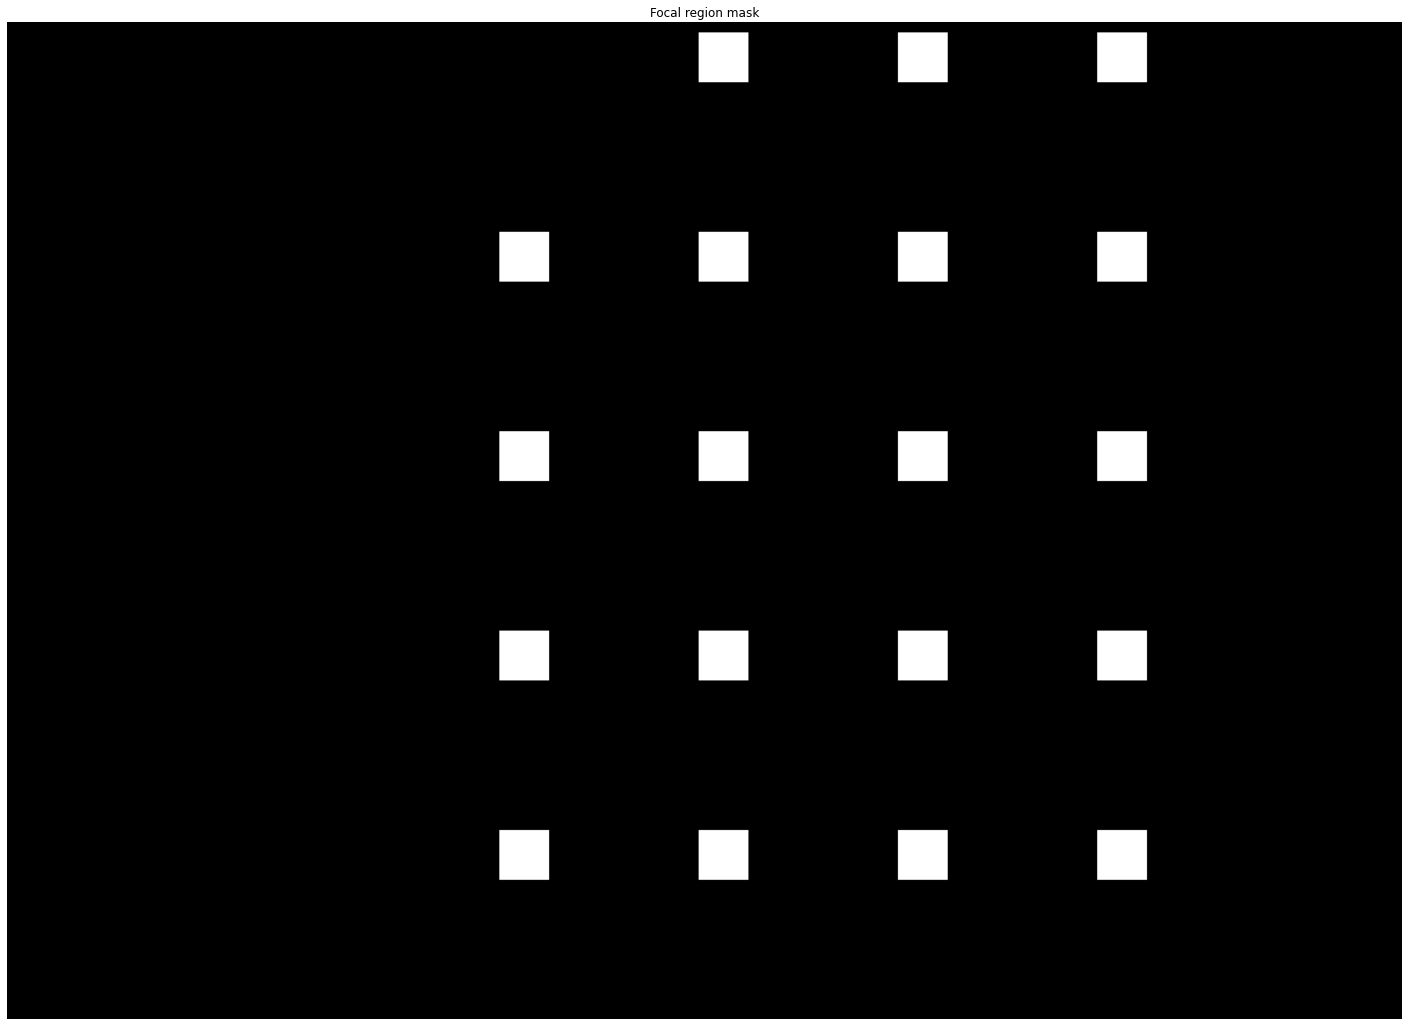

In [29]:
# Scenario 4: Max possible Z focal point of A

relative_focal_point = max_z_focal_point_A / np.array(volume_size_A)
focal_point_on_B = relative_focal_point * np.array(volume_size_B)

focal_region_size = FOCAL_REGION_PROPORTION * np.array(volume_size_B)
focal_region_size = focal_region_size.astype(np.uint16)
print("focal_region_size: ", focal_region_size)
    
# Apply Stochastic focal sampling
focal_point_after_sf, intersection_mask = patch_sampler._apply_stochastic_focal_method(focal_point_on_B, focal_region_size, sampling_prob_map_B)
print("focal_point_after_sf: ", focal_point_after_sf)
visualizer.grid(intersection_mask.transpose(2,1,0), 
                idx_range=[0,33], view='axial', image_type='labelmap', title="Focal region mask")

focal_region_size:  [ 19 144 144]
focal_point_after_sf:  [ 16 145 410]


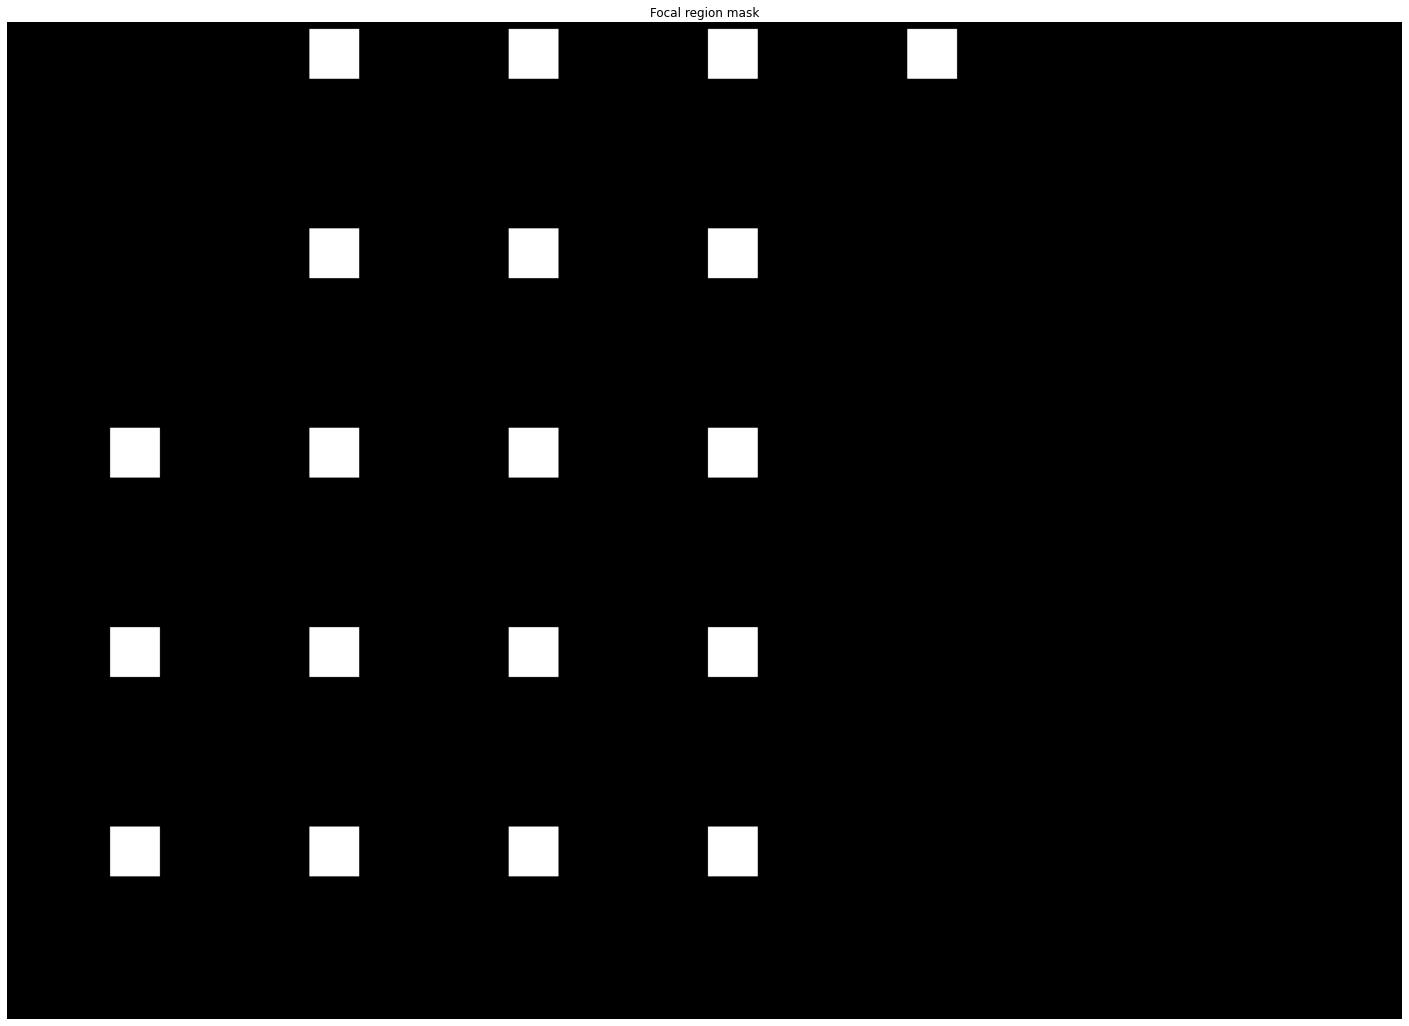

In [30]:
# Scenario 5: Min possible Y focal point of A

relative_focal_point = min_y_focal_point_A / np.array(volume_size_A)
focal_point_on_B = relative_focal_point * np.array(volume_size_B)

focal_region_size = FOCAL_REGION_PROPORTION * np.array(volume_size_B)
focal_region_size = focal_region_size.astype(np.uint16)
print("focal_region_size: ", focal_region_size)
    
# Apply Stochastic focal sampling
focal_point_after_sf, intersection_mask = patch_sampler._apply_stochastic_focal_method(focal_point_on_B, focal_region_size, sampling_prob_map_B)
print("focal_point_after_sf: ", focal_point_after_sf)
visualizer.grid(intersection_mask.transpose(2,1,0), 
                idx_range=[0,33], view='axial', image_type='labelmap', title="Focal region mask")

focal_region_size:  [ 19 144 144]
focal_point_after_sf:  [ 16 390 339]


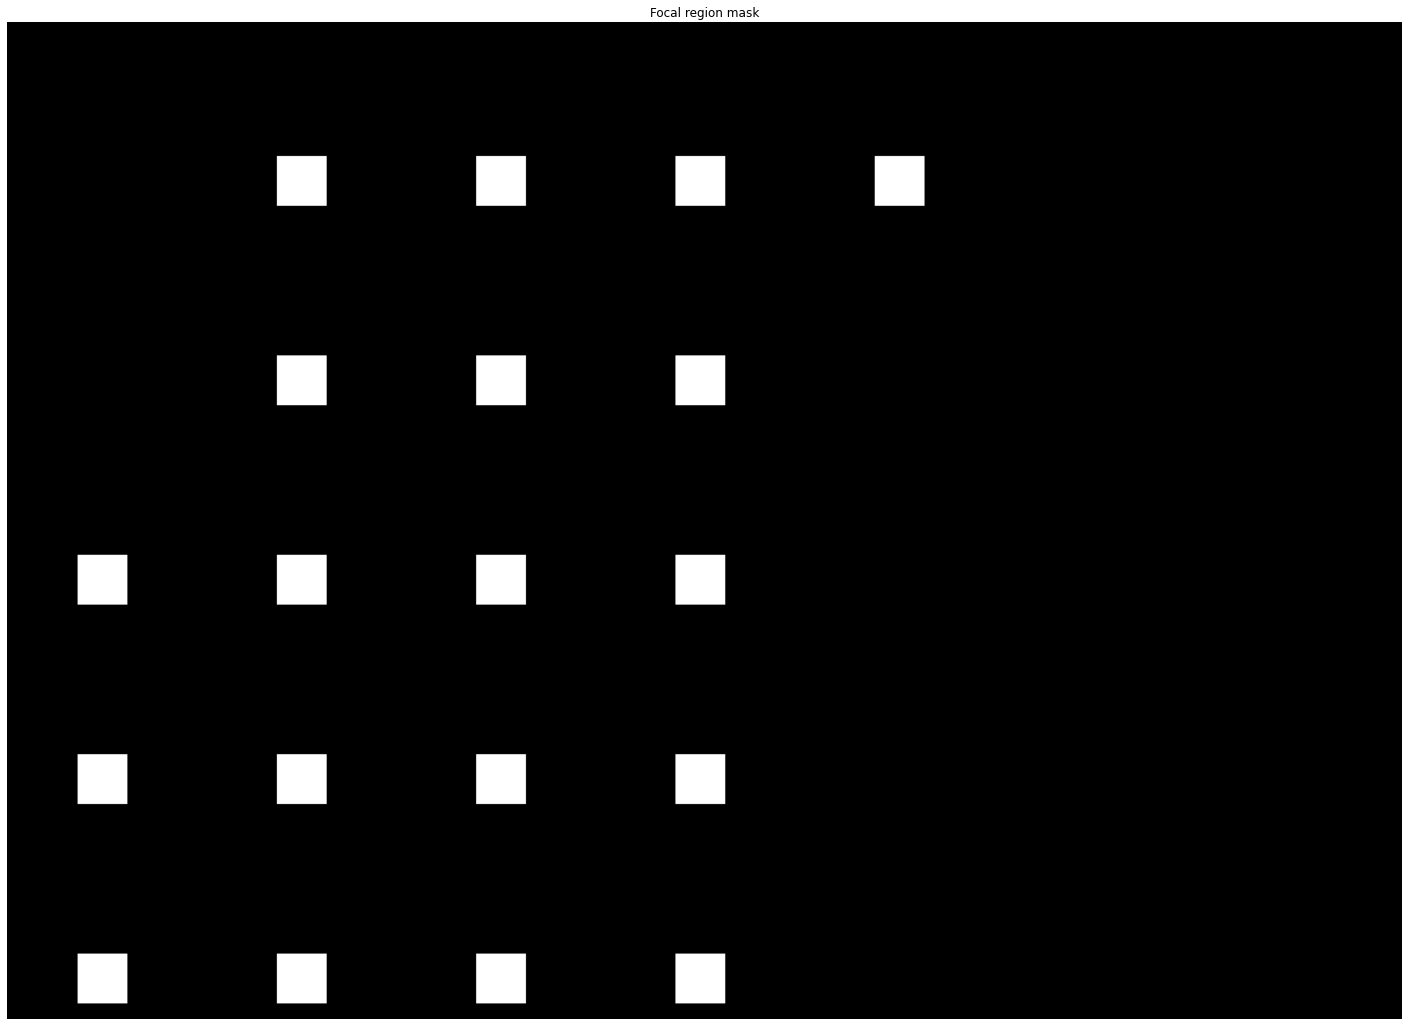

In [31]:
# Scenario 6: Max possible Y focal point of A

relative_focal_point = max_y_focal_point_A / np.array(volume_size_A)
focal_point_on_B = relative_focal_point * np.array(volume_size_B)

focal_region_size = FOCAL_REGION_PROPORTION * np.array(volume_size_B)
focal_region_size = focal_region_size.astype(np.uint16)
print("focal_region_size: ", focal_region_size)
    
# Apply Stochastic focal sampling
focal_point_after_sf, intersection_mask = patch_sampler._apply_stochastic_focal_method(focal_point_on_B, focal_region_size, sampling_prob_map_B)
print("focal_point_after_sf: ", focal_point_after_sf)
visualizer.grid(intersection_mask.transpose(2,1,0), 
                idx_range=[0,33], view='axial', image_type='labelmap', title="Focal region mask")

focal_region_size:  [ 19 144 144]
focal_point_after_sf:  [ 16 331 124]


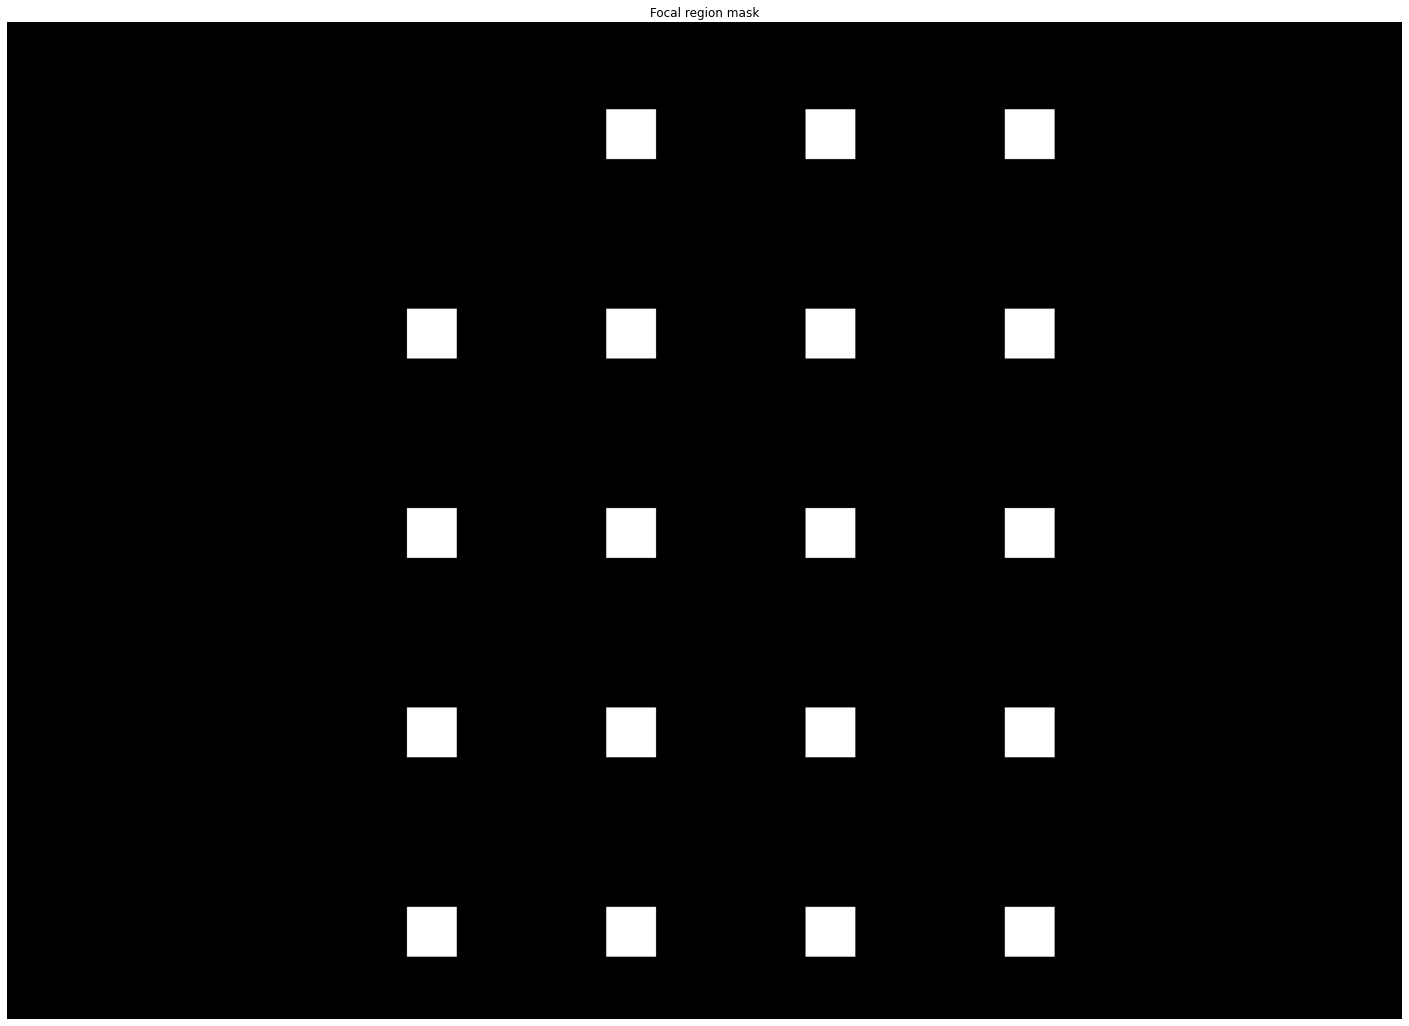

In [32]:
# Scenario 7: Min possible X focal point of A

relative_focal_point = min_x_focal_point_A / np.array(volume_size_A)
focal_point_on_B = relative_focal_point * np.array(volume_size_B)

focal_region_size = FOCAL_REGION_PROPORTION * np.array(volume_size_B)
focal_region_size = focal_region_size.astype(np.uint16)
print("focal_region_size: ", focal_region_size)
    
# Apply Stochastic focal sampling
focal_point_after_sf, intersection_mask = patch_sampler._apply_stochastic_focal_method(focal_point_on_B, focal_region_size, sampling_prob_map_B)
print("focal_point_after_sf: ", focal_point_after_sf)
visualizer.grid(intersection_mask.transpose(2,1,0), 
                idx_range=[0,33], view='axial', image_type='labelmap', title="Focal region mask")

focal_region_size:  [ 19 144 144]
focal_point_after_sf:  [ 16 308 459]


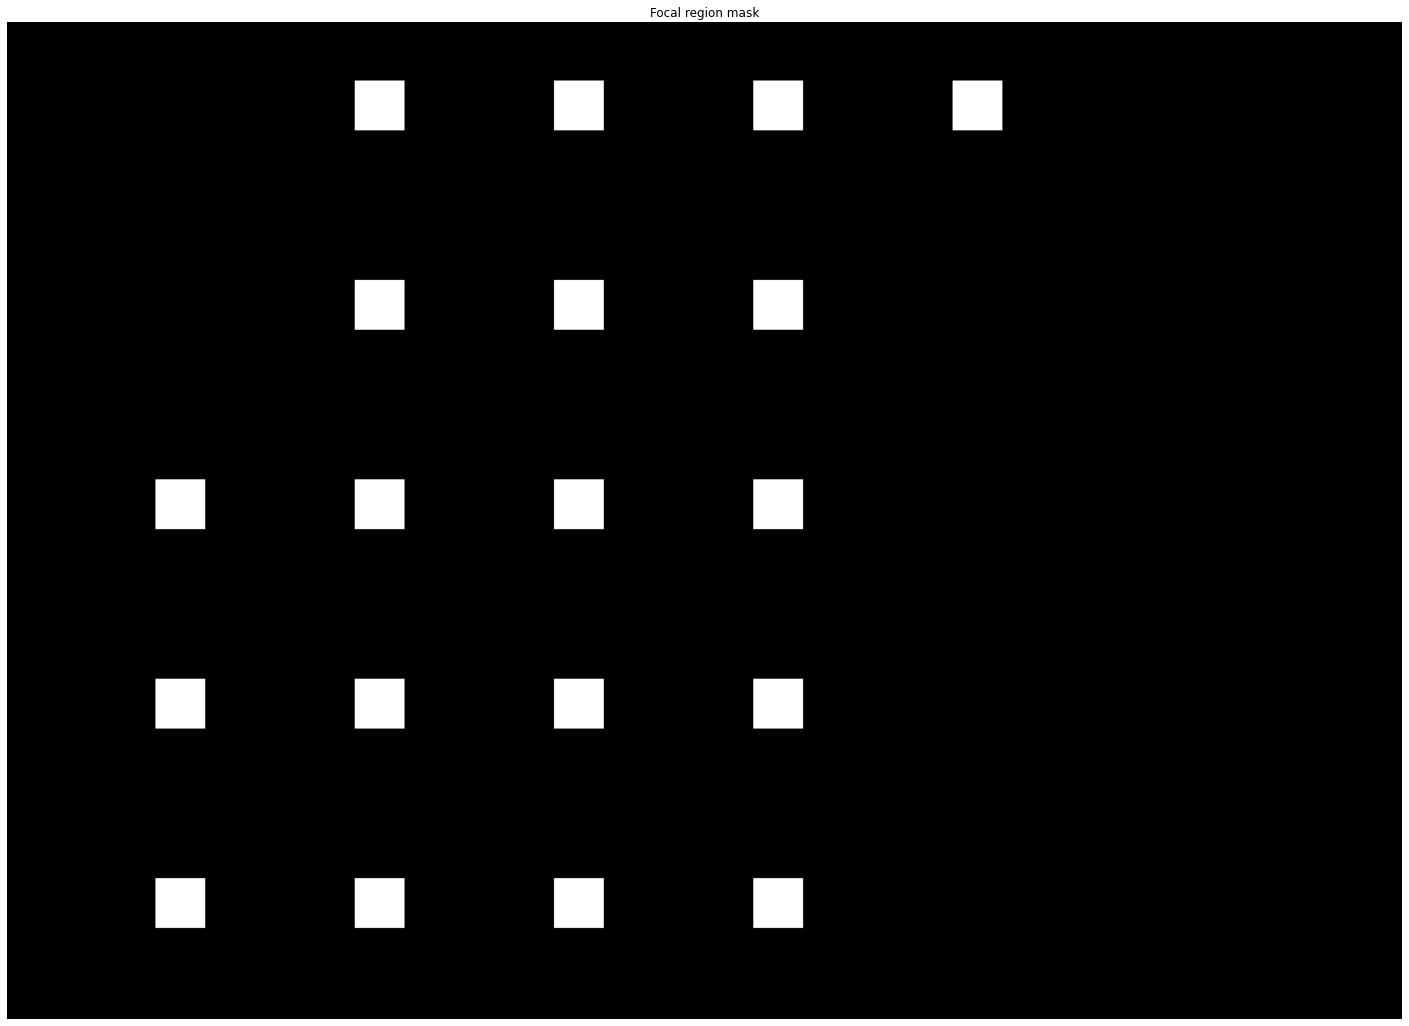

In [33]:
# Scenario 8: Max possible X focal point of A

relative_focal_point = max_x_focal_point_A / np.array(volume_size_A)
focal_point_on_B = relative_focal_point * np.array(volume_size_B)

focal_region_size = FOCAL_REGION_PROPORTION * np.array(volume_size_B)
focal_region_size = focal_region_size.astype(np.uint16)
print("focal_region_size: ", focal_region_size)
    
# Apply Stochastic focal sampling
focal_point_after_sf, intersection_mask = patch_sampler._apply_stochastic_focal_method(focal_point_on_B, focal_region_size, sampling_prob_map_B)
print("focal_point_after_sf: ", focal_point_after_sf)
visualizer.grid(intersection_mask.transpose(2,1,0), 
                idx_range=[0,33], view='axial', image_type='labelmap', title="Focal region mask")